In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from keras.layers import Dense, LSTM, TimeDistributed
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [4]:
data = pd.read_csv(filepath_or_buffer="./Data/growth_rate.csv", index_col="date")

In [5]:
# data.head()
# data.tail()
# data.info()

In [6]:
data = data.apply(pd.to_numeric, errors = "coerce")
#data.info()

In [7]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [8]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

# MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
data.columns

Index(['TCMNOM_Y10', 'TCMNOM_Y2', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [11]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [12]:
values

array([[ 0.00704504,  0.00124224, -0.00560538, ...,  0.00318379,
         0.00479325,  0.00235611],
       [ 0.00710283, -0.01116625, -0.01014656, ...,  0.00137046,
         0.001068  ,  0.00352586],
       [ 0.02463141, -0.02258469, -0.0261959 , ...,  0.01051646,
         0.01920341,  0.02392505],
       ...,
       [ 0.01085129,  0.01056338,  0.00961538, ...,  0.0030581 ,
         0.00088684, -0.00381922],
       [ 0.0105578 , -0.01045296, -0.0031746 , ..., -0.01375496,
        -0.00062024, -0.01495208],
       [-0.00631667,  0.02464789,  0.02547771, ..., -0.00136592,
         0.00265981,  0.00064868]], dtype=float32)

In [13]:
look_back = 5 
time_steps = 1
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)
reframed.tail()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var1(t-4),var2(t-4),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
7925,-0.004299,0.000000,0.000000,0.000871,-0.004520,0.006490,0.002311,0.005479,-0.005512,-0.010274,...,-0.007908,0.000128,-0.006560,0.000000,0.000000,0.002067,-0.002472,0.001985,0.007524,0.001411
7926,-0.005512,-0.010274,-0.009375,-0.022126,0.011167,0.001701,-0.005852,-0.000649,-0.030864,-0.017301,...,0.007524,0.001411,0.015667,0.010676,0.012987,-0.024239,-0.004387,-0.005306,0.002400,0.006019
7927,-0.030864,-0.017301,-0.022082,-0.016906,-0.004369,0.000283,0.004103,0.006491,0.018625,0.007042,...,0.002400,0.006019,0.010851,0.010563,0.009615,-0.011099,-0.008528,0.003058,0.000887,-0.003819
7928,0.018625,0.007042,0.012903,-0.000517,0.000203,-0.001697,-0.000355,0.005546,-0.017327,-0.017483,...,0.000887,-0.003819,0.010558,-0.010453,-0.003175,-0.047969,0.013334,-0.013755,-0.000620,-0.014952
7929,-0.017327,-0.017483,-0.019108,0.001294,0.002478,-0.000567,-0.007908,0.000128,-0.006560,0.000000,...,-0.000620,-0.014952,-0.006317,0.024648,0.025478,-0.001965,0.000772,-0.001366,0.002660,0.000649


In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

/home/tjiang20/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [15]:
#scaled = reframed.values
scaled

array([[0.66063767, 0.44322982, 0.60483811, ..., 0.4296785 , 0.67015511,
        0.31847226],
       [0.660818  , 0.42474545, 0.58801506, ..., 0.40643796, 0.72058476,
        0.36282892],
       [0.71551456, 0.40773591, 0.52855941, ..., 0.42491893, 0.36802818,
        0.24640902],
       ...,
       [0.54234399, 0.41560673, 0.54379951, ..., 0.45004425, 0.62525989,
        0.30772019],
       [0.69677218, 0.45186984, 0.67340425, ..., 0.33807595, 0.60832193,
        0.22104247],
       [0.58458598, 0.41533639, 0.55481588, ..., 0.420582  , 0.64518621,
        0.34250618]])

In [16]:
n_train_hours = int(len(scaled) * 0.7)

train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [17]:
# split into input and outputs
train_X, train_y = train[:, :-8], train[:, -8:]
test_X, test_y = test[:, :-8], test[:, -8:]

In [18]:
train_X.shape

(5547, 40)

In [19]:
test_y.shape

(2378, 8)

In [20]:
train_X = train_X.reshape((train_X.shape[0], 5, 8))
test_X = test_X.reshape((test_X.shape[0], 5, 8))
#train_y = train_y.reshape((train_y.shape[0], 1, 8))
#test_y = test_y.reshape((test_y.shape[0], 1, 8))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5547, 5, 8) (5547, 8) (2378, 5, 8) (2378, 8)


# Building the Model

In [21]:
train_y

array([[0.6315711 , 0.41849088, 0.59530929, ..., 0.4296785 , 0.67015511,
        0.31847226],
       [0.63574997, 0.43750505, 0.60814981, ..., 0.40643796, 0.72058476,
        0.36282892],
       [0.62390424, 0.47633862, 0.74397393, ..., 0.42491893, 0.36802818,
        0.24640902],
       ...,
       [0.63398232, 0.49159241, 0.73618725, ..., 0.33634613, 0.55375486,
        0.27363804],
       [0.72072793, 0.50614693, 0.67929274, ..., 0.4390921 , 0.65813045,
        0.31518243],
       [0.57945624, 0.44137931, 0.8478768 , ..., 0.40252204, 0.63900111,
        0.27540793]])

In [2]:
# model = Sequential()
# model.add(LSTM(units=100, return_sequences= True, input_shape=(train_X.shape[1],train_X.shape[2])))
# model.add(LSTM(units=100, return_sequences=True))
# model.add(LSTM(units=100, return_sequences=True))
# model.add(LSTM(units=100, return_sequences=True))
# model.add(LSTM(units=100))#, return_sequences= True, input_shape=(train_y.shape[1],8)))

# model.add(Dense(units=8))
# model.summary()

In [22]:
model = Sequential()

model.add(LSTM(
    input_shape=(train_X.shape[1],train_X.shape[2]),
    return_sequences=True, units=50))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(
    250,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(train_X.shape[2]))
model.add(Activation("linear"))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 50)             11800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 100)            60400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 100)            80400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 250)               351000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2008      
__________

In [23]:
#model.compile(optimizer='adam', loss='mean_squared_error')
n_batch = 300#len(train_X)
history = model.fit(train_X, train_y, epochs=100, batch_size=n_batch, validation_data=(test_X, test_y))

Train on 5547 samples, validate on 2378 samples
Epoch 1/100
5547/5547 [==============================] - 7s 1ms/step - loss: 0.1199 - val_loss: 0.0240
Epoch 2/100
5547/5547 [==============================] - 2s 319us/step - loss: 0.0118 - val_loss: 0.0070
Epoch 3/100
5547/5547 [==============================] - 2s 319us/step - loss: 0.0055 - val_loss: 0.0039
Epoch 4/100
5547/5547 [==============================] - 2s 321us/step - loss: 0.0045 - val_loss: 0.0034
Epoch 5/100
5547/5547 [==============================] - 2s 321us/step - loss: 0.0043 - val_loss: 0.0034
Epoch 6/100
5547/5547 [==============================] - 2s 326us/step - loss: 0.0043 - val_loss: 0.0034
Epoch 7/100
5547/5547 [==============================] - 2s 323us/step - loss: 0.0042 - val_loss: 0.0034
Epoch 8/100
5547/5547 [==============================] - 2s 322us/step - loss: 0.0041 - val_loss: 0.0034
Epoch 9/100
5547/5547 [==============================] - 2s 323us/step - loss: 0.0041 - val_loss: 0.0034
Epoch 10/

Epoch 78/100
5547/5547 [==============================] - 1s 226us/step - loss: 0.0031 - val_loss: 0.0033
Epoch 79/100
5547/5547 [==============================] - 1s 227us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 80/100
5547/5547 [==============================] - 1s 223us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 81/100
5547/5547 [==============================] - 1s 224us/step - loss: 0.0030 - val_loss: 0.0034
Epoch 82/100
5547/5547 [==============================] - 1s 222us/step - loss: 0.0031 - val_loss: 0.0034
Epoch 83/100
5547/5547 [==============================] - 1s 221us/step - loss: 0.0030 - val_loss: 0.0034
Epoch 84/100
5547/5547 [==============================] - 1s 223us/step - loss: 0.0030 - val_loss: 0.0034
Epoch 85/100
5547/5547 [==============================] - 1s 224us/step - loss: 0.0030 - val_loss: 0.0034
Epoch 86/100
5547/5547 [==============================] - 1s 225us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 87/100
5547/5547 [======================

In [1]:
# from keras.callbacks import ModelCheckpoint

# weight_path="{}_weights.hdf5".format('8to8market_lstm_growth_rate_model')

# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
#                              save_best_only=True, mode='min', save_weights_only = False)
# callbacks_list = [checkpoint]

# multi_model = Sequential()
# multi_model.add(LSTM(
#     input_shape=(train_X.shape[1],train_X.shape[2]),
#     return_sequences=True, units=train_X.shape[1]))

# multi_model.add(LSTM(
#     300,
#     return_sequences=True))
# #multi_model.add(TimeDistributed(Dense(number_of_variables)))
# multi_model.compile(loss="mse", optimizer="adam")
# multi_history = multi_model.fit(train_X, train_y, epochs=50, batch_size=150, validation_data=(test_X, test_y),
#                                 verbose=0, shuffle=False)#, callbacks = callbacks_list)




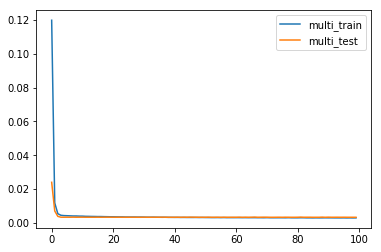

In [25]:
#multi_history = model
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

In [26]:
test_X.shape

(2378, 5, 8)

In [27]:
from keras.models import load_model

#multi_model = load_model("8to8market_lstm_growth_rate_model_weights.hdf5")
multi_model = model
yhat = multi_model.predict(test_X)

In [28]:
test_y[:,0]

array([0.68676762, 0.68101314, 0.71921599, ..., 0.67251477, 0.67159895,
       0.61894353])

In [29]:
yhat[:,0]

array([0.64027226, 0.64084125, 0.64044535, ..., 0.63989276, 0.6405987 ,
       0.63994867], dtype=float32)

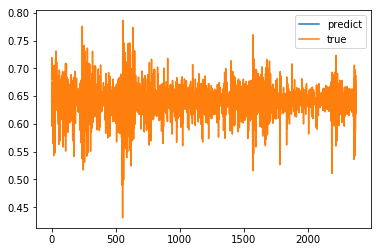

In [32]:
pyplot.plot(yhat[:,0], label='predict')
pyplot.plot(test_y[:,0], label='true')
pyplot.legend()
pyplot.show()

#reshape prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))

test_X.shape

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)

inv_yhat.shape

#inv_yhat = scaler.inverse_transform(inv_yhat)

inv_yhat[-1]

#inv_yhat[:,-8:].shape

inv_yhat = inv_yhat[:,-8:]

inv_yhat[0]

#reshape actual
test_y = test_y.reshape((test_y.shape[0], test_y.shape[2]))

test_y.shape

inv_y = concatenate((test_X[:, :], test_y), axis=1)

#inv_y = scaler.inverse_transform(inv_y)

inv_y[-1]

#inv_y[:,-8:].shape

inv_y = inv_y[:,-8:]

inv_y[:,0].shape

test_y[:,0].shape

#rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
#print('Test RMSE: %.3f' % rmse)

In [33]:
#reshape prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

#yhat.shape

#yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))

#test_X.shape

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)

#inv_yhat.shape

inv_yhat = scaler.inverse_transform(inv_yhat)

#inv_yhat[:,-8:].shape

inv_yhat = inv_yhat[:,-8:]

#inv_yhat.shape

In [34]:
inv_y = concatenate((test_X[:, :], test_y), axis=1)

#inv_y.shape

inv_y = scaler.inverse_transform(inv_y)

inv_y[:,-8:].shape

inv_y = inv_y[:,-8:]

In [35]:
rmse = sqrt(mean_squared_error(yhat[:,0], test_y[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.029


In [36]:
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.009


In [37]:
inv_y[:,0]

array([ 0.0154189 ,  0.01357476,  0.02581761, ...,  0.01085129,
        0.0105578 , -0.00631667])

In [38]:
inv_yhat[:,0]

array([0.00051854, 0.00070089, 0.00057401, ..., 0.00039693, 0.00062316,
       0.00041484])

In [47]:
test_y[:,0]

array([0.68676762, 0.68101314, 0.71921599, ..., 0.67251477, 0.67159895,
       0.61894353])

In [48]:
yhat[:,0]

array([0.64027226, 0.64084125, 0.64044535, ..., 0.63989276, 0.6405987 ,
       0.63994867], dtype=float32)

In [49]:
# predictDates = data.tail(len(inv_y)).index
# actual_chart = go.Scatter(x=predictDates, y=inv_y[:,0], name= 'Actual Price')
# multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat[:,0], name= 'Multi Predict Price')
# py.iplot([multi_predict_chart, actual_chart])


predictDates = data.tail(len(test_y)).index
actual_chart = go.Scatter(x=predictDates, y=test_y[:,0], name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=yhat[:,0], name= 'Multi Predict Price')
py.iplot([multi_predict_chart])

In [50]:
py.iplot([multi_predict_chart, actual_chart])